# C.5. Volatility Modeling

## Module: Options

### DRW New-Hire Learning Program

#### Summer 2022

Questions?
* Contact: Mark Hendricks
* hendricks@uchicago.edu

$$\newcommand{\ivol}{\sigma_{\text{imp}}}$$
$$\newcommand{\vega}{\mathcal{V}}$$

$$\newcommand{\dwF}{dW^{[1]}}$$
$$\newcommand{\dwS}{dW^{[2]}}$$

# Volatility Models

## Motivation

As we have seen, 
* implied volatility is not constant for an underlying
* it varies substantially with **moneyness** (strike vs underlying) and time-to-expiration.
* and it is not stable over time!

Why do we care? Suppose you hold...
* a 3-month call struck at 100
* a 1-month call struck at 90

What is the right hedge ratio?

How is this impacted by the inconsistency across
* strikes
* maturity

## Volatility Surface and Skew

To ensure model (internal) consistency and hopefully (external) performance, we need a 
* volatility surface

In practice, there is much more focus on the 
* volatility curve / smile /skew

That is, the inconsistency of the volatility across strikes is more problematic than across maturities.

## This is about hedging as much as it is about pricing!

To know whether we are hedged, we need to know the true delta.
* Model inconsistency in implied vol will lead to model inconsistency in delta and gamma.

If implied vol were constant (as in BS) for a given point in time, we would still care how it shifts over time!
* Remember the "greek" vega
$$\vega \equiv \frac{\partial f}{\partial \ivol}$$

## Which Type of Model?

You discussed this in depth with DRW.

### Parametric 
* impose structure, 
* which leads to statistical power
* protects against overfitting.

Examples
* polynomials

### Non-parametric and semi-parametric
* flexibility
* "let the data speak"

Examples 
* splines
* regularized (ML) models

### Stochastic Volatility
* specify a stochastic process for volatility
* ensures no-arbitrage
* provides insights beyond the output

Examples
* Local volatility
* SABR
* ZABR?

### Modeling the Discount (yield) Curve

This discussion and its tradeoffs should feel familiar!

# SABR

## Stochastic Alpha Beta Rho (SABR)

The SABR model is used in conjunction with Black's Model.
* Can be used for generalized versions, such as the "Libor Market Model".
* Key is that SABR just handles the implied volatility.
* Provides an input for a pricing model, (most notably, Black.)

Instead of a constant diffusion term, $\sigma$, we want
* not just a function $\sigma(F,t)$
* but rather a stochastic process

## The Model

Suppose the underlying is the forward process, $F$.
* Typically using forwards or futures, as fitting with Black's model.

Under the **forward measure**, this process has no drift!
* So no "$dt$" term in the stochastic differential.
$$dF = \sigma F^{\beta}\dwF$$

Here, $\dwF$ is simply a pure Brownian motion as usual in these equations.
* The superscript is anticipating we will have a second such process.
* It is not an exponent.

### Role of Beta $\beta$
Note that $\beta$ is controlling whether this is
* lognormal: $\beta=1$
* normal: $\beta=0$
* CEV: $0<\beta<1$

Typically, this parameter is not estimated but is set according to the desired model.
* Could parameterize with a regression (in logs) but not typically done.

In interest-rate derivatives, it is typical to choose
* $\beta=0.5$

## Stochastic Volatility

Now onto the stochastic volatility. Model $\sigma$ as a process characterized by
$$\sigma = \nu \sigma \dwS$$

So $\sigma$ is a geometric Brownian motion!
* Why geometric Brownian (lognormal) instead of Brownian (normal)?

## Role of alpha $\alpha$

Alpha, sometimes denoted $\sigma_0$, is the initialized value of this process.
* It is controlling the level of realized volatility.

In the formula below, 
* $\alpha$ is being written as $\sigma_0$ to emphasize this.

## Role of rho $\rho$
The process $\dwS$ is another Brownian motion, different than $\dwF$. 
* Remember the superscript is an identifier, not an exponent!
* They are not necessarily independent.

The parameter, $\rho$, governs the correlation between the two processes (shocks) $\dwF$ and $\dwS$.

### Question
Do you think $\rho$ will typically be positive or negative?
* Why?
* For all assets?

## Role of "nu" $\nu$

Note that $\nu$ is a constant (parameter), and it is the "vol" of the volatility process.

## The Equation

It can be shown that under these dynamics,

$$\ivol(F_0,K) = AB\frac{\phi}{\chi}$$
where, not joking,
<img src="../refs/options/SABRformula.png" width="600" />

### At-the-money

For an ATM option, $\ln(F_0/K)$ is zero, and we get

$$\ivol^*(F_0,K) = \frac{\sigma_0B}{F_0^{1-\beta}}$$

Money implementations make use of this fact to solve for $\alpha$ (denoted here $\sigma_0$) as a function of the other two parameters and the observed ATM implied vol $\ivol^*$:
$$\alpha = \alpha\left(\nu,\rho,\ivol^{*,\text{market}}\right)$$

This reduces the problem from 3 parameters to 2 parameters. 
* For nonlinear equations, even this modest reduction can be helpful.

### Benefit?

This function is a mess, but it is a closed-form solution!
* Traders may need to recompute the volatility curve every day / hour / second.
* A closed-form solution is attractive as it allows this frequent recalculation of the entire curve.

### Missing?
This function 
* has a parameter for expiration $T$
* but it is not a **function**.

What is the difference?

This is in line with what we mentioned above, the main goal is to model the vol curve, and glue together (incompatible?) slices to form the vol surface.

## Fitting SABR

Use observed market implied volatilities to fit SABR on a set of options.

1. Use the reference set of $(F_0,K,\ivol^{\text{mkt}})$.
2. Numerically try sets of parameters $(\alpha,\nu,\rho)$ 
    * or $(\nu, \rho)$ if using the ATM relationship for alpha above.
3. For each parameterization, check how close the SABR vol is to the market implied vol across all securities, using a penalty function of
$$\sum_{i}\left(\ivol^{\text{SABR}}(i) - \ivol^{\text{market}}(i)\right)^2$$
4. Set the parameters that minimize this error.

Now, use the solution parameters to set the implied volatility curve. 
* This gives you $\sigma(F,K)$ to insert into Black's formula.

Use this curve for 
* pricing other strikes / maturities / options on this underyling.
* better measuring the greeks of even these reference securities.

# Delta Hedging

As one example, consider the simple problem of delta hedging.

Given that implied volatility is not constant, we can expect that 
* delta changes when implied vol changes!

This is sometimes referred to as **vanna**
$$\frac{\partial \Delta}{\partial \ivol}$$

In particular, we would now have an augmented delta
$$\text{Delta} = \frac{\partial C}{\partial F} + \frac{\partial C}{\partial \ivol}\frac{\partial \ivol}{\partial F}$$

### Black's Formulas

Black's formula (and Black-Scholes) completely ignores this effect.
* This can cause substantial risk and portfolio variation day-over-day, especially in volatile markets.

### Local Volatility
The famed, "local volatility" model fits a function $\sigma(F,K)$ **exactly** to the market quoted implied vols.

So this is better than SABR, which minimizes the error but does not fit perfectly, right?
* No!
* Local volatility does not get the time dynamics right, such that this vega channel of the hedging ends up being worse than Black Scholes!

# A Look at the Data

In [1]:
import pandas as pd
import numpy as np
import datetime
import warnings

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (12,6)
plt.rcParams['font.size'] = 15
plt.rcParams['legend.fontsize'] = 13

from matplotlib.ticker import (MultipleLocator,
                               FormatStrFormatter,
                               AutoMinorLocator)

import sys
sys.path.insert(0,'../cmds')
from options import *

In [2]:
import numpy.polynomial.polynomial as poly
from numpy import poly1d
from scipy.optimize import fsolve
from scipy.optimize import minimize

In [3]:
LOADFILE = '../data/vol_surfaces.xlsx'
BETA = 1
OBJ = 0

info = pd.read_excel(LOADFILE,sheet_name='descriptions').set_index('specs')
labels = info.columns

sheet = labels[OBJ]

TYPE = 'call'
QUOTE_ED_PX = False

ts, ivol_mkt = load_vol_surface(LOADFILE,sheet)

if info.loc['futures ticker',sheet] == 'ED' and not QUOTE_ED_PX:
    ts['Future Price'] = 1-ts['Future Price']/100

strikes = get_strikes_from_vol_moneyness(TYPE,ivol_mkt,ts)

if info.loc['futures ticker',sheet] == 'ED' and QUOTE_ED_PX:
    if TYPE=='put':
        TYPE = 'call'
    else:
        TYPE = 'put'

In [4]:
def alpha_polynomial(beta, nu, rho, T, volATM, f):
    
    coefs = np.ones(4)
    coefs[0] = (1-beta)**2 * T / (24*f**(2-2*beta))
    coefs[1] = rho * beta * nu * T / (4*f**(1-beta))
    coefs[2] = 1 + (2-3*rho**2) * nu**2 * T / 24
    coefs[3] = -volATM * f**(1-beta)
    
    return np.poly1d(coefs)

In [5]:
def solve_alpha(beta, nu, rho, T, volATM, f):
    coefs = np.ones(4)
    coefs[3] = (1-beta)**2 * T / (24*f**(2-2*beta))
    coefs[2] = rho * beta * nu * T / (4*f**(1-beta))
    coefs[1] = 1 + (2-3*rho**2) * nu**2 * T / 24
    coefs[0] = -volATM * f**(1-beta)

    roots = poly.polyroots(coefs)
    alpha = np.real(roots[np.abs(np.imag(roots))<1e-6][0])
    return alpha

In [6]:
def z(beta, nu, alpha, f, K):
    return (nu/alpha) * (f*K)**((1-beta)/2) * np.log(f/K)

def chi(z, rho):
    return np.log((np.sqrt(1-2*rho*z + z**2) + z - rho) / (1-rho))

In [7]:
def sabr_slim(beta,nu,rho,f,K,T,volATM):

    alpha = solve_alpha(beta, nu, rho, T, volATM, f)
    squareNUM = (((1-beta)**2)/24) * (alpha**2)/((f*K)**(1-beta)) + (1/4) * (rho*beta*nu*alpha)/((f*K)**((1-beta)/2))+((2-3*rho**2)/24)*nu**2
    NUM = alpha * (1 + squareNUM * T)

    squareDEN = 1 + (((1-beta)**2)/24) * (np.log(f/K)**2) + (((1-beta)**4)/1920) * (np.log(f/K)**4)
    DEN = (f*K)**((1-beta)/2) * squareDEN

    sigmaB = (NUM/DEN) * (z(beta,nu,alpha,f,K)/chi(z(beta,nu,alpha,f,K),rho))
    return sigmaB

In [8]:
def sabr(beta,nu,rho,alpha,f,K,T,volATM):

    squareNUM = (((1-beta)**2)/24) * (alpha**2)/((f*K)**(1-beta)) + (1/4) * (rho*beta*nu*alpha)/((f*K)**((1-beta)/2))+((2-3*rho**2)/24)*nu**2
    NUM = alpha * (1 + squareNUM * T)

    squareDEN = 1 + (((1-beta)**2)/24) * (np.log(f/K)**2) + (((1-beta)**4)/1920) * (np.log(f/K)**4)
    DEN = (f*K)**((1-beta)/2) * squareDEN

    sigmaB = (NUM/DEN) * (z(beta,nu,alpha,f,K)/chi(z(beta,nu,alpha,f,K),rho))
    return sigmaB

In [9]:
from pandas.tseries.offsets import Day, BDay
from datetime import date
bdays = BDay()

In [10]:
TARG_T = 1
t = pd.to_datetime(info.loc['option expiration',sheet]) - TARG_T * datetime.timedelta(365)
t += 1 * bdays
t = t.strftime('%Y-%m-%d')

In [11]:
volATM = ivol_mkt.loc[t,'P50dVol']
F = ts.loc[t,'Future Price']
strike_grid = strikes.loc[t]
T = ts.loc[t,'Expiration Option']

ivol_obs = ivol_mkt.loc[t]

In [12]:
def obj_fun(xargs):
    nu = xargs[0]
    rho = xargs[1]
    alpha = xargs[2]
    ivol_mod = np.zeros(len(strike_grid))
    
    for i,K in enumerate(strike_grid):
         ivol_mod[i] = sabr(beta,nu,rho,alpha,F,K,T,volATM)
    
    error = ((ivol_mod - ivol_obs)**2).sum()
    
    return error


def obj_fun_slim(xargs):
    nu = xargs[0]
    rho = xargs[1]
    ivol_mod = np.zeros(len(strike_grid))
    
    for i,K in enumerate(strike_grid):
         ivol_mod[i] = sabr_slim(beta,nu,rho,F,K,T,volATM)
    
    error = ((ivol_mod - ivol_obs)**2).sum()
    
    return error

# Optimizing

In [13]:
beta = BETA
doSLIM = False

In [14]:
x0 = np.array([.6,0,.1])
fun = obj_fun 

if doSLIM:
    x0 = x0[0:2]
    fun = obj_fun_slim
    
optim = minimize(fun,x0)
xstar = optim.x
nustar = xstar[0]
rhostar = xstar[1]

if doSLIM:
    alphastar = solve_alpha(beta,nustar,rhostar[1],T,volATM,F)
else:
    alphastar = xstar[2]
    
if doSLIM:
    ivolSABR = sabr_slim(beta,nustar,rhostar,F,strike_grid,T,volATM)
else:
    ivolSABR = sabr(beta,nustar,rhostar,alphastar,F,strike_grid,T,volATM)

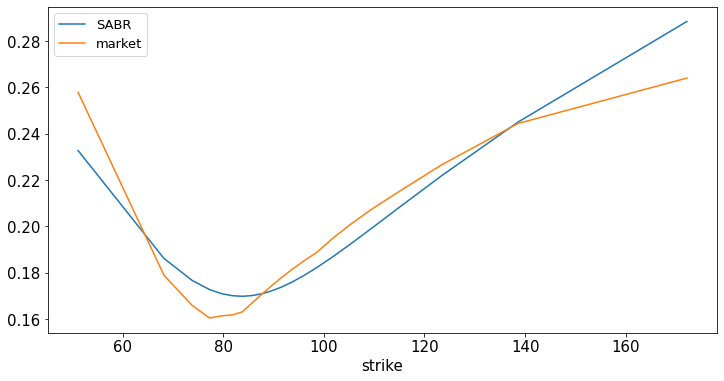

In [15]:
comp = pd.concat([ivolSABR,ivol_obs],axis=1)
comp.columns = ['SABR','market']
comp['strike'] = strike_grid
comp.set_index('strike',inplace=True)
comp.plot();

In [16]:
scalegrid = volATM / np.sqrt(1)
if info.loc['futures ticker',sheet] == 'ED':
    if QUOTE_ED_PX:
        scalegrid /= 5
        
Fpath = np.arange(F*(1-scalegrid),F*(1+scalegrid),F*scalegrid/20)
        
volPath = pd.DataFrame(columns=ivolSABR.index,index=Fpath)
for f in Fpath:
    volPath.loc[f,:] = sabr(beta,nustar,rhostar,alphastar,f,strike_grid,T,volATM)

In [17]:
if TYPE == 'call':
    phi = 1
    isCall = True
    
else:
    phi =-1
    isCall = False
    
deltas = pd.DataFrame(np.array([float(col[1:3])/100 for col in volPath.columns]) * phi, index=volPath.columns,columns = ['delta'])
strikesPath = pd.DataFrame(index=volPath.index, columns=volPath.columns,dtype=float)
for i, col in enumerate(volPath.columns):
    for row in volPath.index:
        strikesPath.loc[row,col] = bs_delta_to_strike(row,deltas.loc[col,'delta'],volPath.loc[row,col],T,isCall=isCall)

if info.loc['futures ticker',sheet] == 'ED':
    if QUOTE_ED_PX:
        strikesPath[strikesPath>100] = np.nan
        strikesPath[strikesPath<85] = np.nan

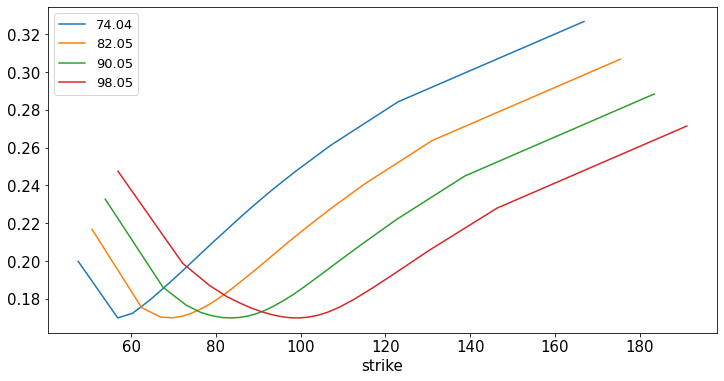

In [18]:
fig, ax = plt.subplots()
chosen = volPath.index[::10]
for row in chosen:
    plotdata = pd.concat([strikesPath.loc[row],volPath.loc[row]],axis=1)
    plotdata.columns = ['strike','vol']
    plotdata.set_index('strike',inplace=True)
    plotdata.plot(ax=ax)

center = round(volPath.shape[1]/2)

plt.legend([f'{c:.2f}' for c in chosen]);


# backbone = volPath.iloc[:,center]
# plotdata = pd.concat([strikesPath.iloc[:,center],backbone],axis=1)
# plotdata.columns = ['strike','vol path']
# plotdata.set_index('strike',inplace=True)
# plotdata.plot(ax=ax,color='black')

# plt.legend([f'{c:.2f}' for c in chosen] + ['vol path']);